In [1]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
from bauer.utils.math import softplus_np

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [34]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr', 'NPC12r', 'NPCr1cm-cluster', 'NPCr1cm-surface', 'NPCr2cm-cluster', 'NPCr2cm-surface']
n_voxels = [0, 1, 100]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

pred = pd.concat(pred)


df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')

r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

  0%|          | 0/1890 [00:00<?, ?it/s]

/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-1_mask-NPCr1cm-cluster_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-1_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-2_mask-NPCr1cm-cluster_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-2_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-3_mask-NPCr1cm-cluster_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-3_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.de

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_2147/3483555600.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


In [35]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-1_trace.netcdf')

In [36]:
n1_evidence_sd = idata.posterior['n1_evidence_sd'].to_dataframe().groupby(['subject', 'n1_evidence_sd_regressors']).mean()
n2_evidence_sd = idata.posterior['n2_evidence_sd'].to_dataframe().groupby(['subject', 'n2_evidence_sd_regressors']).mean()

In [37]:
r2_diff = r2.droplevel('session').unstack(['stimulation_condition'])
r2_diff = r2_diff[('r', 'ips')] - r2_diff[('r', 'vertex')]

In [38]:
n1_evidence_sd_ips = softplus_np(n1_evidence_sd.xs('Intercept', 0, 'n1_evidence_sd_regressors'))
n1_evidence_sd_vertex = softplus_np(n1_evidence_sd.xs('Intercept', 0, 'n1_evidence_sd_regressors') + n1_evidence_sd.xs('stimulation_condition[T.vertex]', 0, 'n1_evidence_sd_regressors'))

In [39]:
n2_evidence_sd_ips = softplus_np(n2_evidence_sd.xs('Intercept', 0, 'n2_evidence_sd_regressors'))
n2_evidence_sd_vertex = softplus_np(n2_evidence_sd.xs('Intercept', 0, 'n2_evidence_sd_regressors') + n2_evidence_sd.xs('stimulation_condition[T.vertex]', 0, 'n2_evidence_sd_regressors'))

In [40]:
n1_evidence_sd = pd.concat((n1_evidence_sd_ips, n1_evidence_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)
n2_evidence_sd = pd.concat((n2_evidence_sd_ips, n2_evidence_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)

total_evidence_sd = n1_evidence_sd.loc[:, (slice(None), 'n1_evidence_sd')].droplevel(1, 1) + n2_evidence_sd.loc[:, (slice(None), 'n2_evidence_sd')].droplevel(1, 1)

In [41]:
n1_evidence_sd_diff = n1_evidence_sd['ips'] - n1_evidence_sd['vertex']
n2_evidence_sd_diff = n2_evidence_sd['ips'] - n2_evidence_sd['vertex']
total_evidence_sd_diff = (total_evidence_sd['ips'] - total_evidence_sd['vertex']).to_frame('total_evidence_sd')

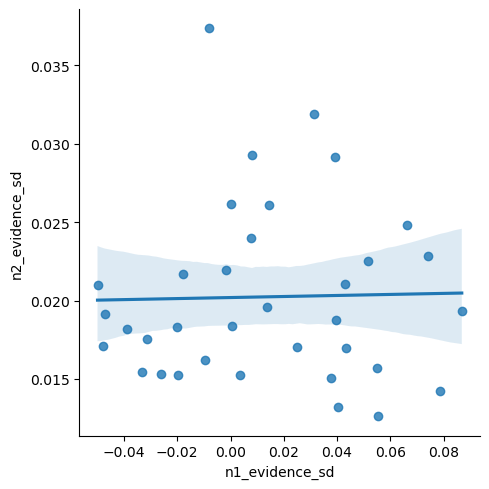

In [42]:
import seaborn as sns
sns.lmplot(data=n1_evidence_sd_diff.join(n2_evidence_sd_diff), x='n1_evidence_sd', y='n2_evidence_sd') 

In [43]:
r2_diff.to_frame('r').join(n1_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd']))

n         r          CI95%     p-val  \
mask            n_voxels                                                  
NPC12r          0        pearson  35 -0.005843  [-0.34, 0.33]  0.973426   
                1        pearson  35  0.033409   [-0.3, 0.36]  0.848897   
                100      pearson  35 -0.296382  [-0.57, 0.04]  0.083840   
NPCr            0        pearson  35  0.062896  [-0.28, 0.39]  0.719640   
                1        pearson  35 -0.160540  [-0.47, 0.18]  0.356910   
                100      pearson  35 -0.002443  [-0.34, 0.33]  0.988887   
NPCr1cm-cluster 0        pearson  32 -0.308032  [-0.59, 0.05]  0.086318   
                1        pearson  23 -0.219367  [-0.58, 0.21]  0.314562   
                100      pearson  35 -0.086258  [-0.41, 0.25]  0.622227   
NPCr1cm-surface 0        pearson  31 -0.058203    [-0.4, 0.3]  0.755796   
                1        pearson  13 -0.204111  [-0.68, 0.39]  0.503574   
                100      pearson  35  0.030382  [-0.31, 0.36]  0.862453   
NPCr2cm-cluster 0        pearson  35  0.125713  [-0.22, 0.44]  0.471782   
                1        pearson  35  0.008837  [-0.33, 0.34]  0.959819   
                100      pearson  35 -0.195481   [-0.5, 0.15]  0.260427   
NPCr2cm-surface 0        pearson  35 -0.268137  [-0.55, 0.07]  0.119380   
                1        pearson  35  0.048505  [-0.29, 0.38]  0.782011   
                100      pearson  35 -0.075360   [-0.4, 0.26]  0.667008   

                                   BF10     power  
mask            n_voxels                           
NPC12r          0        pearson   0.21  0.049685  
                1        pearson  0.214  0.053760  
                100      pearson  0.884  0.416673  
NPCr            0        pearson  0.224  0.064576  
                1        pearson  0.316  0.152396  
                100      pearson   0.21  0.049579  
NPCr1cm-cluster 0        pearson  0.899  0.411919  
                1        pearson  0.417  0.173478  
                100      pearson  0.236  0.078074  
NPCr1cm-surface 0        pearson  0.234  0.060765  
                1        pearson  0.418  0.103011  
                100      pearson  0.213  0.053031  
NPCr2cm-cluster 0        pearson   0.27  0.111368  
                1        pearson  0.211  0.049850  
                100      pearson  0.387  0.205005  
NPCr2cm-surface 0        pearson  0.675  0.349707  
                1        pearson  0.218  0.058449  
                100      pearson   0.23  0.071222

In [44]:
r2_diff.to_frame('r').join(n1_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n1_evidence_sd'], method='spearman'))

n         r          CI95%     p-val  \
mask            n_voxels                                                   
NPC12r          0        spearman  35  0.030252  [-0.31, 0.36]  0.863034   
                1        spearman  35  0.044538  [-0.29, 0.37]  0.799460   
                100      spearman  35 -0.310364  [-0.58, 0.03]  0.069592   
NPCr            0        spearman  35  0.080952   [-0.26, 0.4]  0.643875   
                1        spearman  35 -0.107283  [-0.43, 0.23]  0.539600   
                100      spearman  35  0.046218  [-0.29, 0.37]  0.792055   
NPCr1cm-cluster 0        spearman  32 -0.233138  [-0.54, 0.13]  0.199094   
                1        spearman  23 -0.137352  [-0.52, 0.29]  0.532001   
                100      spearman  35 -0.101681  [-0.42, 0.24]  0.561096   
NPCr1cm-surface 0        spearman  31 -0.037097  [-0.39, 0.32]  0.842946   
                1        spearman  13 -0.214286  [-0.68, 0.38]  0.482054   
                100      spearman  35  0.018207  [-0.32, 0.35]  0.917318   
NPCr2cm-cluster 0        spearman  35  0.064986  [-0.27, 0.39]  0.710718   
                1        spearman  35 -0.046218  [-0.37, 0.29]  0.792055   
                100      spearman  35 -0.266947  [-0.55, 0.07]  0.121092   
NPCr2cm-surface 0        spearman  35 -0.269748  [-0.55, 0.07]  0.117091   
                1        spearman  35  0.054622  [-0.28, 0.38]  0.755311   
                100      spearman  35 -0.121849  [-0.44, 0.22]  0.485620   

                                      power  
mask            n_voxels                     
NPC12r          0        spearman  0.053001  
                1        spearman  0.057046  
                100      spearman  0.451364  
NPCr            0        spearman  0.074615  
                1        spearman  0.094125  
                100      spearman  0.057625  
NPCr1cm-cluster 0        spearman  0.253622  
                1        spearman  0.095881  
                100      spearman  0.089478  
NPCr1cm-surface 0        spearman  0.054054  
                1        spearman  0.108846  
                100      spearman  0.050802  
NPCr2cm-cluster 0        spearman  0.065603  
                1        spearman  0.057625  
                100      spearman  0.346996  
NPCr2cm-surface 0        spearman  0.353394  
                1        spearman  0.060853  
                100      spearman  0.107501

In [45]:
r2_diff.to_frame('r').join(n2_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd']))

n         r           CI95%     p-val  \
mask            n_voxels                                                   
NPC12r          0        pearson  35 -0.150432   [-0.46, 0.19]  0.388375   
                1        pearson  35 -0.275273   [-0.56, 0.06]  0.109491   
                100      pearson  35 -0.093266   [-0.41, 0.25]  0.594105   
NPCr            0        pearson  35  0.143151    [-0.2, 0.45]  0.412004   
                1        pearson  35 -0.419131   [-0.66, -0.1]  0.012205   
                100      pearson  35 -0.378768  [-0.63, -0.05]  0.024847   
NPCr1cm-cluster 0        pearson  32 -0.108616   [-0.44, 0.25]  0.554030   
                1        pearson  23  0.101349   [-0.32, 0.49]  0.645420   
                100      pearson  35 -0.150826   [-0.46, 0.19]  0.387117   
NPCr1cm-surface 0        pearson  31 -0.086224   [-0.43, 0.28]  0.644650   
                1        pearson  13  0.194835    [-0.4, 0.67]  0.523562   
                100      pearson  35 -0.233577   [-0.53, 0.11]  0.176874   
NPCr2cm-cluster 0        pearson  35  0.049366   [-0.29, 0.38]  0.778236   
                1        pearson  35 -0.358445  [-0.62, -0.03]  0.034481   
                100      pearson  35 -0.248755   [-0.54, 0.09]  0.149593   
NPCr2cm-surface 0        pearson  35 -0.090408   [-0.41, 0.25]  0.605509   
                1        pearson  35 -0.242579    [-0.53, 0.1]  0.160298   
                100      pearson  35 -0.332179     [-0.6, 0.0]  0.051226   

                                   BF10     power  
mask            n_voxels                           
NPC12r          0        pearson  0.301  0.139326  
                1        pearson   0.72  0.366166  
                100      pearson  0.241  0.083005  
NPCr            0        pearson  0.291  0.130505  
                1        pearson  4.293  0.724969  
                100      pearson  2.361  0.626540  
NPCr1cm-cluster 0        pearson   0.26  0.090965  
                1        pearson  0.286  0.074279  
                100      pearson  0.301  0.139818  
NPCr1cm-surface 0        pearson  0.247  0.074471  
                1        pearson  0.411  0.097983  
                100      pearson  0.505  0.275295  
NPCr2cm-cluster 0        pearson  0.219  0.058770  
                1        pearson  1.801  0.574556  
                100      pearson   0.57  0.306825  
NPCr2cm-surface 0        pearson  0.239  0.080944  
                1        pearson  0.542  0.293768  
                100      pearson  1.306  0.506835

In [46]:
r2_diff.to_frame('r').join(n2_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['n2_evidence_sd'], method='spearman'))

n         r           CI95%     p-val  \
mask            n_voxels                                                    
NPC12r          0        spearman  35 -0.091597   [-0.41, 0.25]  0.600755   
                1        spearman  35 -0.209244   [-0.51, 0.13]  0.227681   
                100      spearman  35 -0.081793    [-0.4, 0.26]  0.640426   
NPCr            0        spearman  35  0.033333    [-0.3, 0.36]  0.849236   
                1        spearman  35 -0.366947  [-0.62, -0.04]  0.030134   
                100      spearman  35 -0.353782  [-0.61, -0.02]  0.037074   
NPCr1cm-cluster 0        spearman  32 -0.117669   [-0.45, 0.24]  0.521272   
                1        spearman  23  0.111660    [-0.32, 0.5]  0.611993   
                100      spearman  35  0.019608   [-0.32, 0.35]  0.910983   
NPCr1cm-surface 0        spearman  31 -0.167339    [-0.49, 0.2]  0.368236   
                1        spearman  13  0.060440   [-0.51, 0.59]  0.844502   
                100      spearman  35 -0.140336    [-0.45, 0.2]  0.421352   
NPCr2cm-cluster 0        spearman  35  0.060784   [-0.28, 0.39]  0.728692   
                1        spearman  35 -0.239216    [-0.53, 0.1]  0.166355   
                100      spearman  35 -0.205882    [-0.5, 0.14]  0.235407   
NPCr2cm-surface 0        spearman  35 -0.066106   [-0.39, 0.27]  0.705950   
                1        spearman  35 -0.147339    [-0.46, 0.2]  0.398314   
                100      spearman  35 -0.340896  [-0.61, -0.01]  0.045070   

                                      power  
mask            n_voxels                     
NPC12r          0        spearman  0.081793  
                1        spearman  0.228878  
                100      spearman  0.075147  
NPCr            0        spearman  0.053741  
                1        spearman  0.596409  
                100      spearman  0.562532  
NPCr1cm-cluster 0        spearman  0.098388  
                1        spearman  0.079739  
                100      spearman  0.051001  
NPCr1cm-surface 0        spearman  0.147610  
                1        spearman  0.053474  
                100      spearman  0.127227  
NPCr2cm-cluster 0        spearman  0.063574  
                1        spearman  0.286787  
                100      spearman  0.222885  
NPCr2cm-surface 0        spearman  0.066168  
                1        spearman  0.135519  
                100      spearman  0.529277

In [47]:
r2_diff.to_frame('r').join(total_evidence_sd_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['total_evidence_sd']))

n         r          CI95%     p-val  \
mask            n_voxels                                                  
NPC12r          0        pearson  35 -0.027310  [-0.36, 0.31]  0.876247   
                1        pearson  35 -0.006471  [-0.34, 0.33]  0.970568   
                100      pearson  35 -0.305721  [-0.58, 0.03]  0.074096   
NPCr            0        pearson  35  0.082546   [-0.26, 0.4]  0.637340   
                1        pearson  35 -0.218394  [-0.51, 0.12]  0.207526   
                100      pearson  35 -0.056661  [-0.38, 0.28]  0.746471   
NPCr1cm-cluster 0        pearson  32 -0.317897   [-0.6, 0.03]  0.076217   
                1        pearson  23 -0.206732  [-0.57, 0.22]  0.343924   
                100      pearson  35 -0.106691  [-0.42, 0.23]  0.541853   
NPCr1cm-surface 0        pearson  31 -0.068803  [-0.41, 0.29]  0.713043   
                1        pearson  13 -0.185554  [-0.67, 0.41]  0.543902   
                100      pearson  35 -0.003486  [-0.34, 0.33]  0.984145   
NPCr2cm-cluster 0        pearson  35  0.131079  [-0.21, 0.44]  0.452920   
                1        pearson  35 -0.042623  [-0.37, 0.29]  0.807916   
                100      pearson  35 -0.228459  [-0.52, 0.11]  0.186825   
NPCr2cm-surface 0        pearson  35 -0.277449  [-0.56, 0.06]  0.106602   
                1        pearson  35  0.013102  [-0.32, 0.34]  0.940452   
                100      pearson  35 -0.121916  [-0.44, 0.22]  0.485378   

                                   BF10     power  
mask            n_voxels                           
NPC12r          0        pearson  0.213  0.052362  
                1        pearson   0.21  0.049714  
                100      pearson  0.974  0.439751  
NPCr            0        pearson  0.234  0.075630  
                1        pearson  0.451  0.245714  
                100      pearson  0.221  0.061720  
NPCr1cm-cluster 0        pearson   0.99  0.435291  
                1        pearson  0.394  0.158804  
                100      pearson  0.252  0.093621  
NPCr1cm-surface 0        pearson  0.238  0.065295  
                1        pearson  0.403  0.093227  
                100      pearson   0.21  0.049602  
NPCr2cm-cluster 0        pearson  0.276  0.116960  
                1        pearson  0.216  0.056412  
                100      pearson  0.486  0.265098  
NPCr2cm-surface 0        pearson  0.735  0.371252  
                1        pearson  0.211  0.050201  
                100      pearson  0.266  0.107567

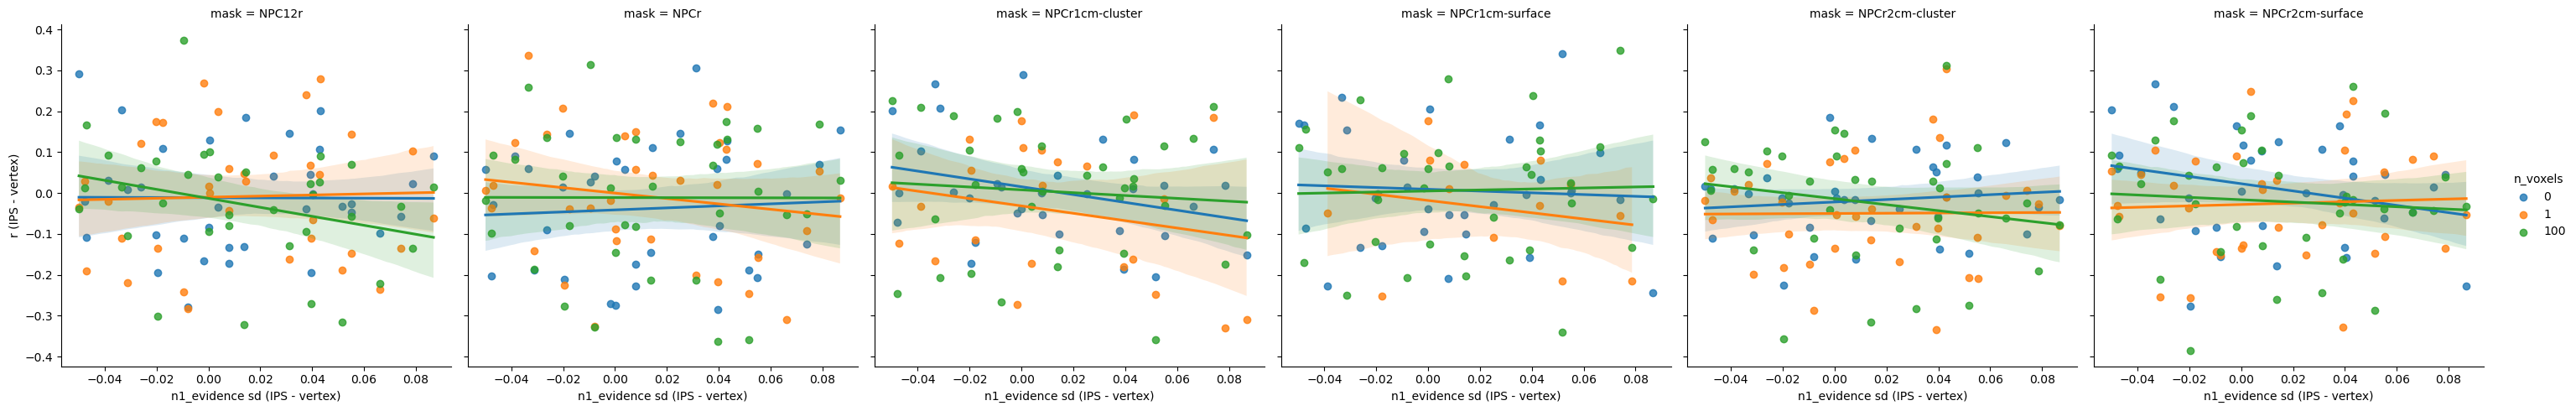

In [48]:
g = sns.lmplot(x='n1_evidence_sd', y='r', data=r2_diff.to_frame('r').join(n1_evidence_sd_diff).reset_index(), hue='n_voxels', col='mask')
g.set_xlabels('n1_evidence sd (IPS - vertex)')
g.set_ylabels('r (IPS - vertex)')

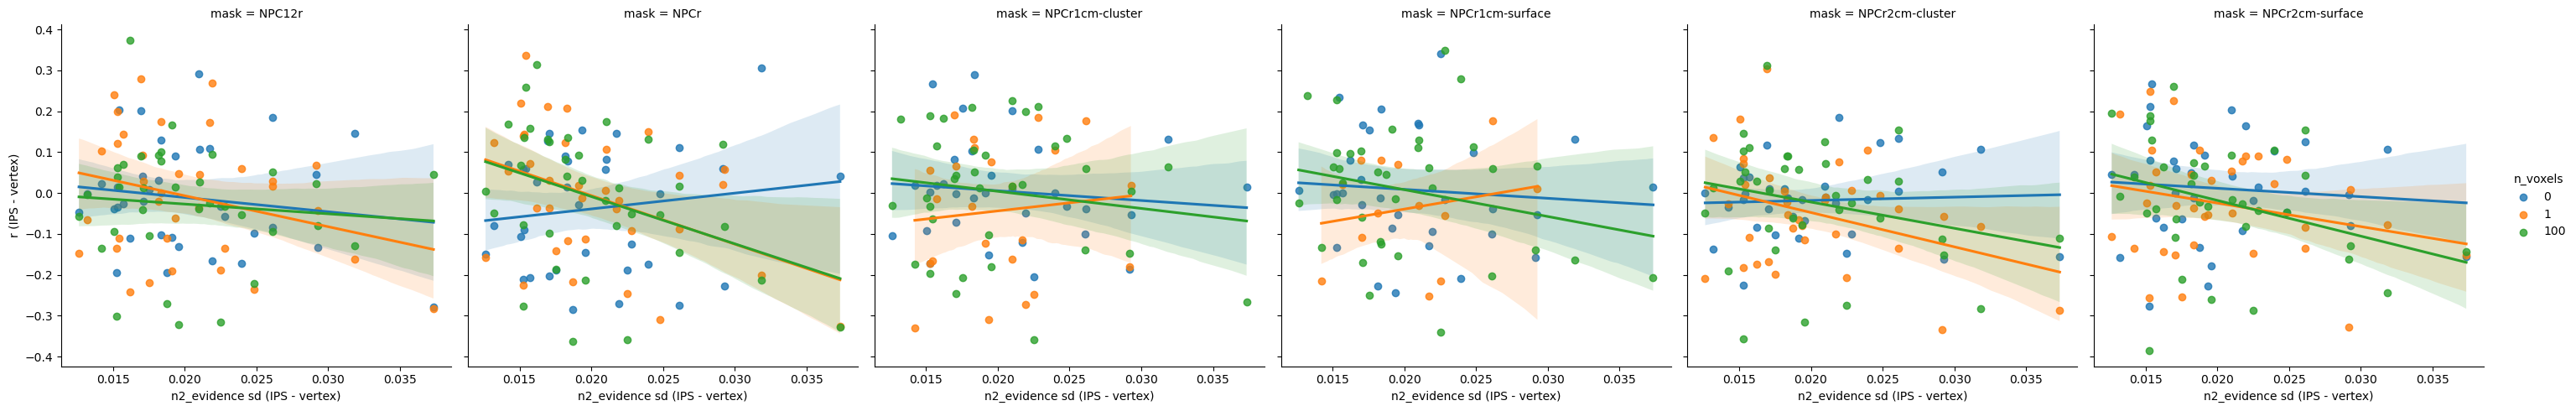

In [49]:
g = sns.lmplot(x='n2_evidence_sd', y='r', data=r2_diff.to_frame('r').join(n2_evidence_sd_diff).reset_index(), hue='n_voxels', col='mask')
g.set_xlabels('n2_evidence sd (IPS - vertex)')
g.set_ylabels('r (IPS - vertex)')

# Model 5

In [50]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-5_trace.netcdf')

In [51]:
perceptual_noise_sd = idata.posterior['perceptual_noise_sd'].to_dataframe().groupby(['subject', 'perceptual_noise_sd_regressors']).mean()
memory_noise_sd = idata.posterior['memory_noise_sd'].to_dataframe().groupby(['subject', 'memory_noise_sd_regressors']).mean()

In [52]:
perceptual_noise_sd_ips = softplus_np(perceptual_noise_sd.xs('Intercept', 0, 'perceptual_noise_sd_regressors'))
perceptual_noise_sd_vertex = softplus_np(perceptual_noise_sd.xs('Intercept', 0, 'perceptual_noise_sd_regressors') + perceptual_noise_sd.xs('stimulation_condition[T.vertex]', 0, 'perceptual_noise_sd_regressors'))

In [53]:
memory_noise_sd_ips = softplus_np(memory_noise_sd.xs('Intercept', 0, 'memory_noise_sd_regressors'))
memory_noise_sd_vertex = softplus_np(memory_noise_sd.xs('Intercept', 0, 'memory_noise_sd_regressors') + memory_noise_sd.xs('stimulation_condition[T.vertex]', 0, 'memory_noise_sd_regressors'))

In [54]:
perceptual_noise_sd = pd.concat((perceptual_noise_sd_ips, perceptual_noise_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)
memory_noise_sd = pd.concat((memory_noise_sd_ips, memory_noise_sd_vertex), keys=['ips', 'vertex'], names=['stimulation_condition'], axis=1)

In [55]:
perceptual_noise_diff = perceptual_noise_sd['ips'] - perceptual_noise_sd['vertex']
memory_noise_diff = memory_noise_sd['ips'] - memory_noise_sd['vertex']

In [56]:
r2_diff.to_frame('r').join(perceptual_noise_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['perceptual_noise_sd'], method='pearson'))

n         r          CI95%     p-val  \
mask            n_voxels                                                  
NPC12r          0        pearson  35  0.035062   [-0.3, 0.36]  0.841515   
                1        pearson  35 -0.053385  [-0.38, 0.28]  0.760687   
                100      pearson  35 -0.235686  [-0.53, 0.11]  0.172886   
NPCr            0        pearson  35  0.162121  [-0.18, 0.47]  0.352130   
                1        pearson  35 -0.228379  [-0.52, 0.11]  0.186982   
                100      pearson  35 -0.268378  [-0.55, 0.07]  0.119035   
NPCr1cm-cluster 0        pearson  32 -0.110295  [-0.44, 0.25]  0.547883   
                1        pearson  23  0.116455   [-0.31, 0.5]  0.596696   
                100      pearson  35  0.149421  [-0.19, 0.46]  0.391608   
NPCr1cm-surface 0        pearson  31 -0.198467  [-0.52, 0.17]  0.284484   
                1        pearson  13  0.007716  [-0.55, 0.56]  0.980041   
                100      pearson  35  0.037995   [-0.3, 0.37]  0.828444   
NPCr2cm-cluster 0        pearson  35  0.209046  [-0.13, 0.51]  0.228131   
                1        pearson  35 -0.116947  [-0.43, 0.23]  0.503470   
                100      pearson  35 -0.176095  [-0.48, 0.17]  0.311590   
NPCr2cm-surface 0        pearson  35 -0.125595  [-0.44, 0.22]  0.472203   
                1        pearson  35  0.021168  [-0.31, 0.35]  0.903933   
                100      pearson  35 -0.256906  [-0.54, 0.08]  0.136274   

                                   BF10     power  
mask            n_voxels                           
NPC12r          0        pearson  0.214  0.054188  
                1        pearson   0.22  0.060344  
                100      pearson  0.514  0.279562  
NPCr            0        pearson  0.319  0.154527  
                1        pearson  0.486  0.264941  
                100      pearson  0.676  0.350258  
NPCr1cm-cluster 0        pearson  0.261  0.092292  
                1        pearson  0.295  0.082474  
                100      pearson  0.299  0.138072  
NPCr1cm-surface 0        pearson  0.386  0.189934  
                1        pearson  0.341  0.049042  
                100      pearson  0.215  0.054999  
NPCr2cm-cluster 0        pearson  0.423  0.228522  
                1        pearson  0.261  0.102789  
                100      pearson  0.344  0.174390  
NPCr2cm-surface 0        pearson   0.27  0.111247  
                1        pearson  0.212  0.051241  
                100      pearson  0.611  0.324518

In [57]:
r2_diff.to_frame('r').join(perceptual_noise_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['perceptual_noise_sd'], method='spearman'))

n         r          CI95%     p-val  \
mask            n_voxels                                                   
NPC12r          0        spearman  35 -0.013725  [-0.35, 0.32]  0.937625   
                1        spearman  35 -0.036695   [-0.37, 0.3]  0.834234   
                100      spearman  35 -0.244818   [-0.53, 0.1]  0.156355   
NPCr            0        spearman  35  0.055462  [-0.28, 0.38]  0.751664   
                1        spearman  35 -0.182073  [-0.49, 0.16]  0.295183   
                100      spearman  35 -0.329412    [-0.6, 0.0]  0.053314   
NPCr1cm-cluster 0        spearman  32 -0.161657   [-0.48, 0.2]  0.376739   
                1        spearman  23  0.123518   [-0.3, 0.51]  0.574461   
                100      spearman  35  0.145658   [-0.2, 0.46]  0.403776   
NPCr1cm-surface 0        spearman  31 -0.255242  [-0.56, 0.11]  0.165806   
                1        spearman  13 -0.021978  [-0.57, 0.54]  0.943186   
                100      spearman  35  0.051821  [-0.29, 0.38]  0.767505   
NPCr2cm-cluster 0        spearman  35  0.149580  [-0.19, 0.46]  0.391098   
                1        spearman  35 -0.084034  [-0.41, 0.26]  0.631267   
                100      spearman  35 -0.161905  [-0.47, 0.18]  0.352782   
NPCr2cm-surface 0        spearman  35 -0.170028  [-0.48, 0.17]  0.328816   
                1        spearman  35  0.082913   [-0.26, 0.4]  0.635840   
                100      spearman  35 -0.256583  [-0.54, 0.08]  0.136785   

                                      power  
mask            n_voxels                     
NPC12r          0        spearman  0.050264  
                1        spearman  0.054631  
                100      spearman  0.298466  
NPCr            0        spearman  0.061207  
                1        spearman  0.183452  
                100      spearman  0.499735  
NPCr1cm-cluster 0        spearman  0.144044  
                1        spearman  0.086732  
                100      spearman  0.133487  
NPCr1cm-surface 0        spearman  0.287921  
                1        spearman  0.049562  
                100      spearman  0.059716  
NPCr2cm-cluster 0        spearman  0.138269  
                1        spearman  0.076595  
                100      spearman  0.154234  
NPCr2cm-surface 0        spearman  0.165539  
                1        spearman  0.075866  
                100      spearman  0.323808

In [58]:
r2_diff.to_frame('r').join(memory_noise_diff).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['memory_noise_sd']))

n         r           CI95%     p-val  \
mask            n_voxels                                                   
NPC12r          0        pearson  35 -0.161644   [-0.47, 0.18]  0.353568   
                1        pearson  35  0.120384   [-0.22, 0.44]  0.490921   
                100      pearson  35 -0.191482   [-0.49, 0.15]  0.270497   
NPCr            0        pearson  35 -0.062353   [-0.39, 0.28]  0.721965   
                1        pearson  35 -0.126284   [-0.44, 0.22]  0.469757   
                100      pearson  35 -0.053921   [-0.38, 0.28]  0.758355   
NPCr1cm-cluster 0        pearson  32 -0.355613  [-0.63, -0.01]  0.045777   
                1        pearson  23 -0.128655    [-0.51, 0.3]  0.558521   
                100      pearson  35 -0.200411    [-0.5, 0.14]  0.248358   
NPCr1cm-surface 0        pearson  31 -0.074775   [-0.42, 0.29]  0.689316   
                1        pearson  13  0.110716   [-0.47, 0.62]  0.718787   
                100      pearson  35 -0.001017   [-0.33, 0.33]  0.995373   
NPCr2cm-cluster 0        pearson  35  0.115104   [-0.23, 0.43]  0.510265   
                1        pearson  35  0.050121   [-0.29, 0.38]  0.774933   
                100      pearson  35 -0.116258   [-0.43, 0.23]  0.506002   
NPCr2cm-surface 0        pearson  35 -0.196706    [-0.5, 0.15]  0.257394   
                1        pearson  35  0.082667    [-0.26, 0.4]  0.636846   
                100      pearson  35  0.009295   [-0.32, 0.34]  0.957739   

                                   BF10     power  
mask            n_voxels                           
NPC12r          0        pearson  0.318  0.153882  
                1        pearson  0.264  0.106070  
                100      pearson  0.377  0.198400  
NPCr            0        pearson  0.224  0.064315  
                1        pearson   0.27  0.111950  
                100      pearson   0.22  0.060563  
NPCr1cm-cluster 0        pearson  1.484  0.527647  
                1        pearson  0.304  0.090004  
                100      pearson  0.399  0.213355  
NPCr1cm-surface 0        pearson  0.241  0.068196  
                1        pearson  0.362  0.064270  
                100      pearson   0.21  0.049561  
NPCr2cm-cluster 0        pearson  0.259  0.101073  
                1        pearson  0.219  0.059055  
                100      pearson   0.26  0.102145  
NPCr2cm-surface 0        pearson   0.39  0.207058  
                1        pearson  0.234  0.075707  
                100      pearson  0.211  0.049881

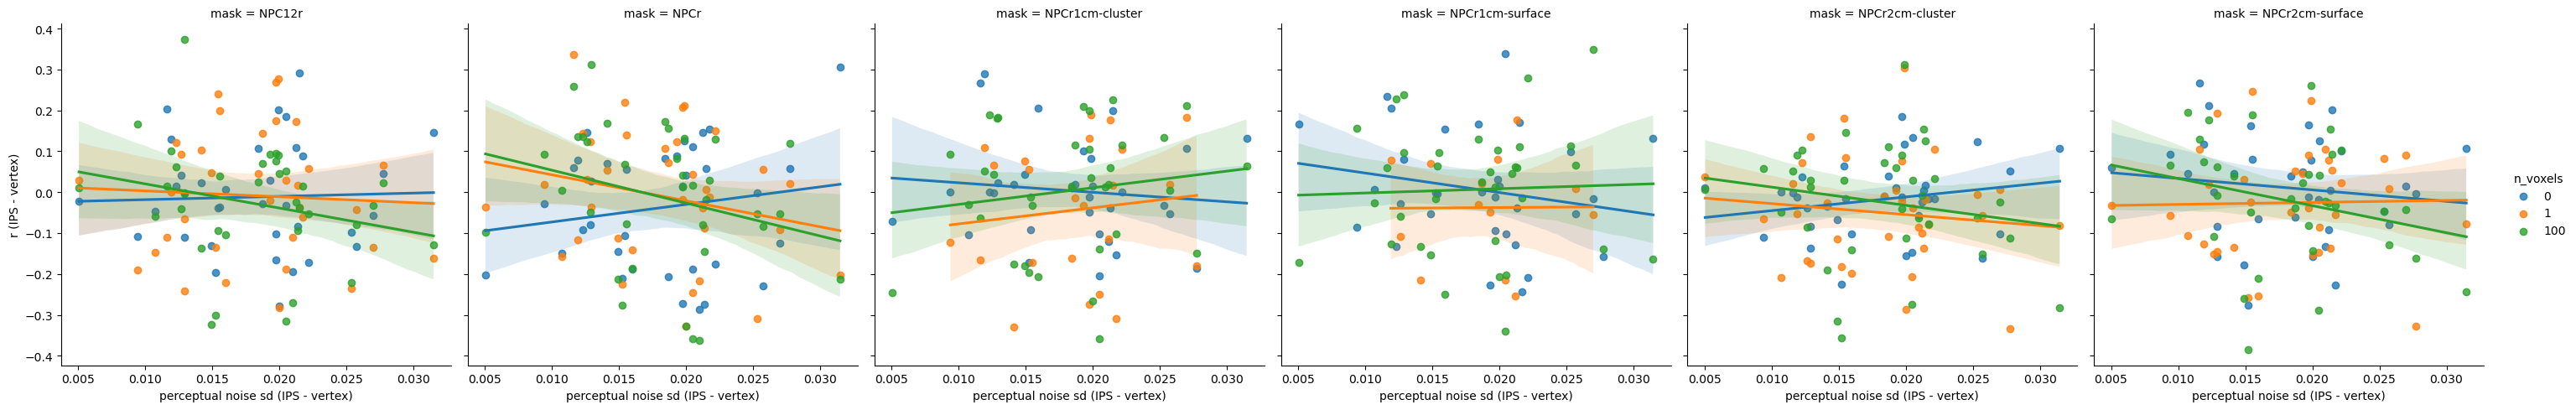

In [59]:
g = sns.lmplot(x='perceptual_noise_sd', y='r', data=r2_diff.to_frame('r').join(perceptual_noise_diff).reset_index(), hue='n_voxels', col='mask')
g.set_xlabels('perceptual noise sd (IPS - vertex)')
g.set_ylabels('r (IPS - vertex)')

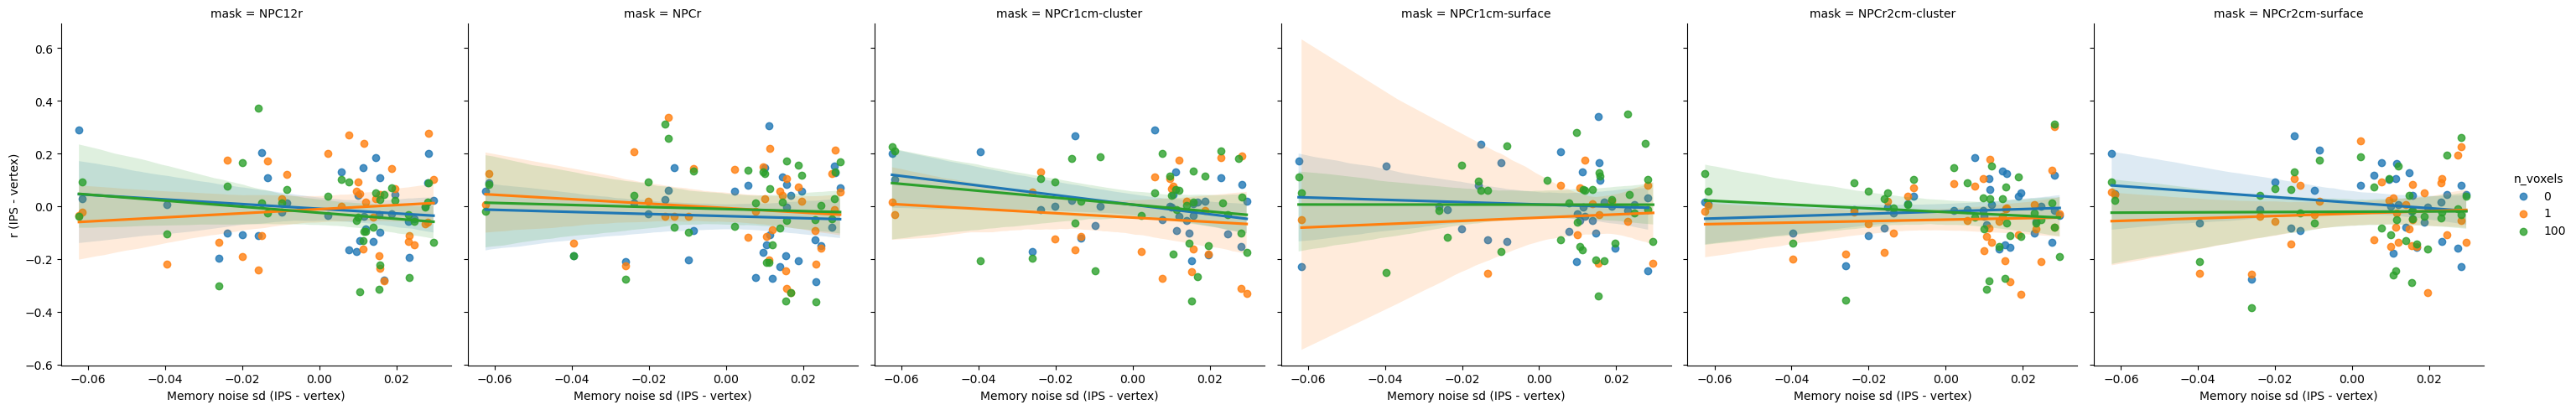

In [60]:
g = sns.lmplot(x='memory_noise_sd', y='r', data=r2_diff.to_frame('r').join(memory_noise_diff).reset_index(), hue='n_voxels', col='mask')
g.set_xlabels('Memory noise sd (IPS - vertex)')
g.set_ylabels('r (IPS - vertex)')

# Model 6

In [61]:
import arviz as az
idata = az.from_netcdf('/data/ds-tmsrisk/derivatives/cogmodels/model-6_trace.netcdf')

In [62]:
diff_evidence_sd = idata.posterior['evidence_sd'].to_dataframe().groupby(['subject', 'evidence_sd_regressors']).mean()

In [63]:
r2_diff.to_frame('r').join(diff_evidence_sd).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['evidence_sd'], method='pearson'))

n         r          CI95%     p-val  \
mask            n_voxels                                                  
NPC12r          0        pearson  35  0.000730  [-0.33, 0.33]  0.996680   
                1        pearson  35  0.033869   [-0.3, 0.36]  0.846841   
                100      pearson  35 -0.150757  [-0.46, 0.19]  0.387339   
NPCr            0        pearson  35  0.131124  [-0.21, 0.44]  0.452762   
                1        pearson  35 -0.135047  [-0.45, 0.21]  0.439236   
                100      pearson  35 -0.245191   [-0.53, 0.1]  0.155704   
NPCr1cm-cluster 0        pearson  32 -0.087318  [-0.42, 0.27]  0.634643   
                1        pearson  23  0.083858  [-0.34, 0.48]  0.703638   
                100      pearson  35  0.142966   [-0.2, 0.45]  0.412614   
NPCr1cm-surface 0        pearson  31 -0.289267  [-0.58, 0.07]  0.114487   
                1        pearson  13  0.184566  [-0.41, 0.67]  0.546089   
                100      pearson  35  0.063778  [-0.28, 0.39]  0.715872   
NPCr2cm-cluster 0        pearson  35  0.171634  [-0.17, 0.48]  0.324200   
                1        pearson  35 -0.069233  [-0.39, 0.27]  0.692704   
                100      pearson  35 -0.086218  [-0.41, 0.25]  0.622389   
NPCr2cm-surface 0        pearson  35 -0.165187  [-0.47, 0.18]  0.342973   
                1        pearson  35  0.066500  [-0.27, 0.39]  0.704278   
                100      pearson  35 -0.209063  [-0.51, 0.13]  0.228091   

                                   BF10     power  
mask            n_voxels                           
NPC12r          0        pearson   0.21  0.049559  
                1        pearson  0.214  0.053877  
                100      pearson  0.301  0.139731  
NPCr            0        pearson  0.276  0.117008  
                1        pearson   0.28  0.121264  
                100      pearson  0.554  0.299254  
NPCr1cm-cluster 0        pearson  0.245  0.076039  
                1        pearson  0.277  0.066306  
                100      pearson   0.29  0.130288  
NPCr1cm-surface 0        pearson  0.735  0.358450  
                1        pearson  0.403  0.092736  
                100      pearson  0.224  0.065005  
NPCr2cm-cluster 0        pearson  0.336  0.167847  
                1        pearson  0.227  0.067798  
                100      pearson  0.236  0.078047  
NPCr2cm-surface 0        pearson  0.324  0.158727  
                1        pearson  0.225  0.066369  
                100      pearson  0.423  0.228553

In [64]:
r2_diff.to_frame('r').join(diff_evidence_sd).groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['r'], d['evidence_sd'], method='spearman'))

n         r          CI95%     p-val  \
mask            n_voxels                                                   
NPC12r          0        spearman  35 -0.019888  [-0.35, 0.32]  0.909716   
                1        spearman  35  0.026331  [-0.31, 0.36]  0.880653   
                100      spearman  35 -0.116807  [-0.43, 0.23]  0.503984   
NPCr            0        spearman  35  0.058543  [-0.28, 0.38]  0.738337   
                1        spearman  35 -0.103081  [-0.42, 0.24]  0.555685   
                100      spearman  35 -0.282633  [-0.56, 0.06]  0.099951   
NPCr1cm-cluster 0        spearman  32 -0.058651    [-0.4, 0.3]  0.749837   
                1        spearman  23  0.105731   [-0.32, 0.5]  0.631127   
                100      spearman  35  0.185714  [-0.16, 0.49]  0.285464   
NPCr1cm-surface 0        spearman  31 -0.289516  [-0.58, 0.07]  0.114161   
                1        spearman  13  0.203297  [-0.39, 0.68]  0.505315   
                100      spearman  35  0.078431   [-0.26, 0.4]  0.654264   
NPCr2cm-cluster 0        spearman  35  0.198599   [-0.14, 0.5]  0.252749   
                1        spearman  35 -0.000560  [-0.33, 0.33]  0.997452   
                100      spearman  35 -0.082073   [-0.4, 0.26]  0.639279   
NPCr2cm-surface 0        spearman  35 -0.134174  [-0.45, 0.21]  0.442227   
                1        spearman  35  0.163305  [-0.18, 0.47]  0.348577   
                100      spearman  35 -0.196639   [-0.5, 0.15]  0.257560   

                                      power  
mask            n_voxels                     
NPC12r          0        spearman  0.051043  
                1        spearman  0.052164  
                100      spearman  0.102658  
NPCr            0        spearman  0.062550  
                1        spearman  0.090614  
                100      spearman  0.383486  
NPCr1cm-cluster 0        spearman  0.061356  
                1        spearman  0.076530  
                100      spearman  0.189137  
NPCr1cm-surface 0        spearman  0.358993  
                1        spearman  0.102558  
                100      spearman  0.073053  
NPCr2cm-cluster 0        spearman  0.210260  
                1        spearman  0.049558  
                100      spearman  0.075326  
NPCr2cm-surface 0        spearman  0.120305  
                1        spearman  0.156138  
                100      spearman  0.206945